# Feasible Hypercubemap (FHCM) Generation

**Author**: Benjamin Urben<br>
**Email**: burben@student.ethz.ch / benjamin.urben@hotmail.ch<br>
**Context**: Master Thesis on "Use of Conditional Variational Autoencoder (cVAE) in the design of connections"<br>
**Institution**: ETH Zürich, Institute of Structural Engineering (IBK)

**Description**:

In this file, a method to create a feasible hypercubemap (FHCM) is introduced and utilized to generate the FHCM for a given dataset. Furthermore, the resulting FHCM is briefly analyzed.

**Dependencies**: 
- `Datareader.py`
- `Settings.py`

**Generates**:
- `Saved Variables\hypercubemap.npy`
- `Saved Variables\hypercubemap_mapping.npy`

## Setup

### Import

In [1]:
from DataReader import DataReader
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import time

from Settings import Directory, Plotting_Parameters

plot_params = Plotting_Parameters()

### Load Data

In [2]:
datareader = DataReader()
df_full = datareader.load('Knee_Connection_Output_red.csv')
df = df_full.copy()

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks
Extended_Database_filtered_converted.csv
extended_profiles_iterV2_1.csv
extended_profiles_iter_1.csv
GAL_Generated_Data.csv
Knee_Connection_Output_red.csv
Knee_parallel_I_Off0_Output_red_Q1.xlsx
Knee_parallel_I_Off0_Output_red_Q4.xlsx
Knee_parallel_I_Output_Q1.xlsx
Knee_parallel_I_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Output_red_Q4.xlsx
Knee_widener_I_Output_Off0_red_Q1.xlsx
Knee_widener_I_Output_red_Q1.xlsx
_OLD
Knee_Connection_Output_red.csv: (714385, 53)


### Define Features

These are the Dimensions/Dependencies which are considered in creating the FHCM.

In [4]:
features = ['h_x', 'b_x', 'tw_x', 'tf_x', 'A_x', 'Av_x', 'Iy_x',
       'Wely_x', 'Wply_x', 'fy_x', 'tau_x', 'Vpl_x', 'Mpl_x',
       'h_y', 'b_y', 'tw_y', 'tf_y', 'A_y', 'Av_y', 'Iy_y',
       'Wely_y', 'Wply_y', 'fy_y', 'tau_y', 'Vpl_y', 'Mpl_y',
       'Gamma', 't_stiffc', 'h_wid', 'b_wid', 'd_wid', 't_fwid', 't_wwid', 'Offset']

In [5]:
for feature in features:
    if feature not in df.columns:
        print(f"Feature {feature} not found in DataFrame.")
        continue

### Define number of bins

In [6]:
m = 8

## Generation

Since iterating over the hyperubces ($N_{HC}=D^m=20^8$) is infeasible, iterate over each datapoint ($\approx 700'000$) and find the location (coordinates) in the hypercubespace.

In [8]:
def find_bins(datapoint, bounds, m):
    bin_widths = (bounds[:, 1] - bounds[:, 0]) / m
    if np.any(datapoint < bounds[:, 0]) or np.any(datapoint > bounds[:, 1]):
        return None
    
    bin_indices = ((datapoint - bounds[:, 0]) / bin_widths).astype(int)
    bin_indices = np.clip(bin_indices, 0, m - 1)
    
    return tuple(bin_indices)

In [9]:
bounds = np.array([[df_full[feature].min(), df_full[feature].max()] for feature in features])
hypercubemap = np.zeros((len(df_full), len(features)))

for i,data in enumerate(df_full[features].values):
    if i % 10000 == 0:
        print(f"Processing datapoint {i/len(df_full):.2%}")
    hypercubemap[i,:] = find_bins(data, bounds, m)


Processing datapoint 0.00%
Processing datapoint 1.40%
Processing datapoint 2.80%
Processing datapoint 4.20%
Processing datapoint 5.60%
Processing datapoint 7.00%
Processing datapoint 8.40%
Processing datapoint 9.80%
Processing datapoint 11.20%
Processing datapoint 12.60%
Processing datapoint 14.00%
Processing datapoint 15.40%
Processing datapoint 16.80%
Processing datapoint 18.20%
Processing datapoint 19.60%
Processing datapoint 21.00%
Processing datapoint 22.40%
Processing datapoint 23.80%
Processing datapoint 25.20%
Processing datapoint 26.60%
Processing datapoint 28.00%
Processing datapoint 29.40%
Processing datapoint 30.80%
Processing datapoint 32.20%
Processing datapoint 33.60%
Processing datapoint 35.00%
Processing datapoint 36.39%
Processing datapoint 37.79%
Processing datapoint 39.19%
Processing datapoint 40.59%
Processing datapoint 41.99%
Processing datapoint 43.39%
Processing datapoint 44.79%
Processing datapoint 46.19%
Processing datapoint 47.59%
Processing datapoint 48.99%


#### Save

In [10]:
hypercubemap_unique, mapping = np.unique(hypercubemap, axis=0, return_inverse=True)

In [ ]:
np.save(r"Saved Variables\hypercubemap.npy", hypercubemap_unique)
np.save(r"Saved Variables\hypercubemap_mapping.npy", mapping)
import pickle
    
with open("Saved Variables\hypercube_features.json", "wb") as file: 
    pickle.dump(features, file)


## Evaluate

In [12]:
n_HC = len(features)**m
print(f"Number of hypercubes in hypercubespace: {n_HC}")
print(f"Number of occupied hypercubes: {len(hypercubemap_unique)}")
print(f"Percentage of occupied hypercubes: {len(hypercubemap_unique)/n_HC:.10%}")
print(f"Average number of datapoints per hypercube: {len(df_full)/len(hypercubemap_unique):.2f}")

Number of hypercubes in hypercubespace: 1785793904896
Number of occupied hypercubes: 115352
Percentage of occupied hypercubes: 0.0000064594%
Average number of datapoints per hypercube: 6.19


In [48]:
# Convert each row in hypercubemap to a tuple to represent a hypercube index
hypercube_indices = [tuple(row.astype(int)) for row in hypercubemap]

# Count how many datapoints fall into each hypercube
hypercube_counts = Counter(hypercube_indices)

# Count how many hypercubes contain 1, 2, 3, ... datapoints
occupancy_distribution = Counter(hypercube_counts.values())

x = sorted(occupancy_distribution)
y = [occupancy_distribution[k] for k in x]

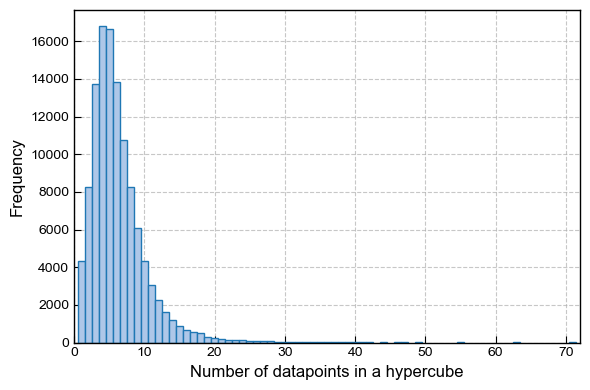

In [63]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.bar(x, y, 
        facecolor=plot_params.morecolors[1], 
        edgecolor=plot_params.morecolors[0], 
        width=1.0,
        zorder=2)
plt.xlabel("Number of datapoints in a hypercube")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.7, zorder=0)
plt.xlim(0, max(x) + 1)
plt.tight_layout()
plt.yscale('linear')
plt.show()

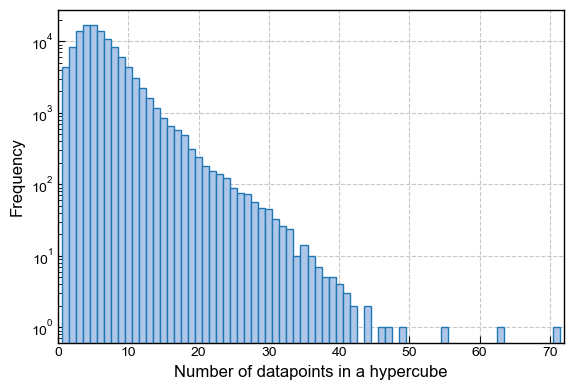

In [64]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.bar(x, y, 
        facecolor=plot_params.morecolors[1], 
        edgecolor=plot_params.morecolors[0], 
        width=1.0,
        zorder=2)
plt.xlabel("Number of datapoints in a hypercube")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.7, zorder=0)
plt.xlim(0, max(x) + 1)
plt.tight_layout()
plt.yscale('log')
plt.show()

### Random sample and check if feasible

In [24]:
def check():
    rand_point = np.random.uniform(bounds[:, 0], bounds[:, 1], size=len(features))
    coords = find_bins(rand_point, bounds, m)
    if np.any(np.all(hypercubemap_unique == coords, axis=1)):
        return True
    else:
        return False

In [25]:
for i in range(10_000):
    if check():
        print(i)
        break

C:\Users\benja\AppData\Local\Temp\ipykernel_1940\1220540224.py:6: RuntimeWarning: invalid value encountered in divide
  bin_indices = ((datapoint - bounds[:, 0]) / bin_widths).astype(int)
C:\Users\benja\AppData\Local\Temp\ipykernel_1940\1220540224.py:6: RuntimeWarning: invalid value encountered in cast
  bin_indices = ((datapoint - bounds[:, 0]) / bin_widths).astype(int)


As expected, no random point is feasible, since the domain is so large.

### Check coverage

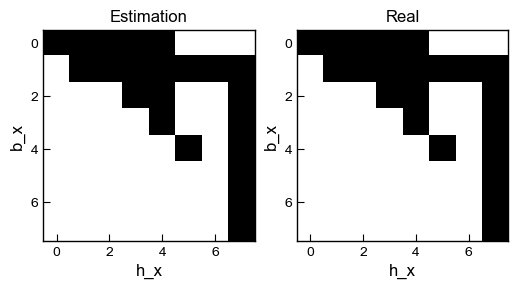

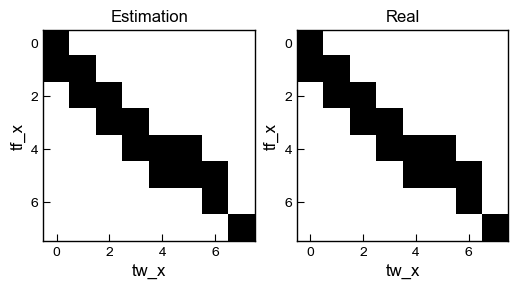

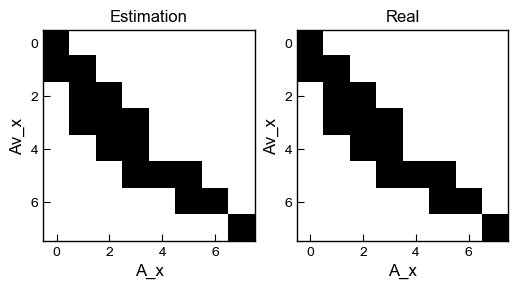

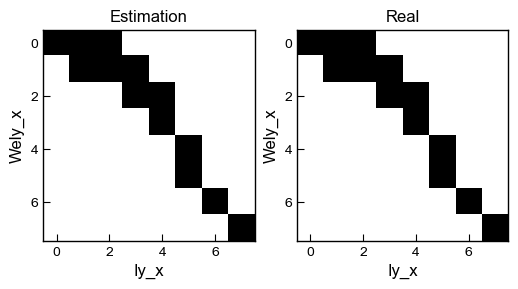

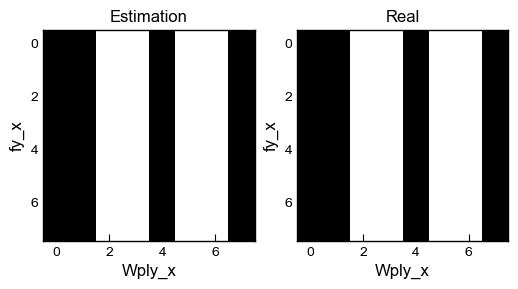

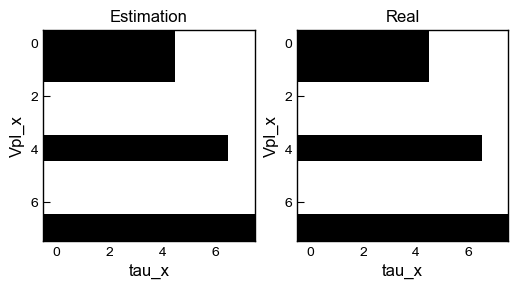

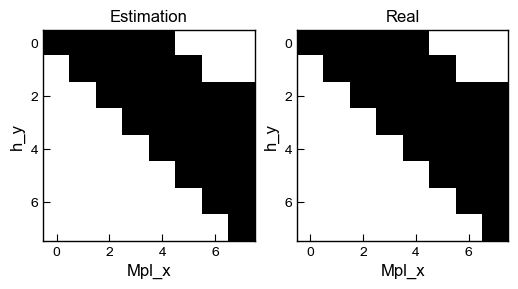

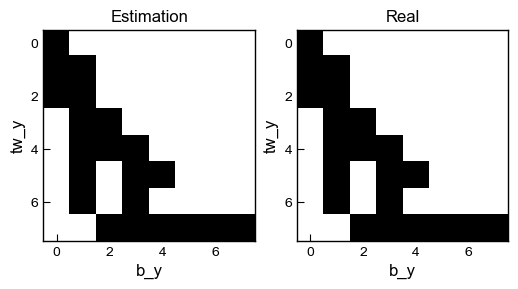

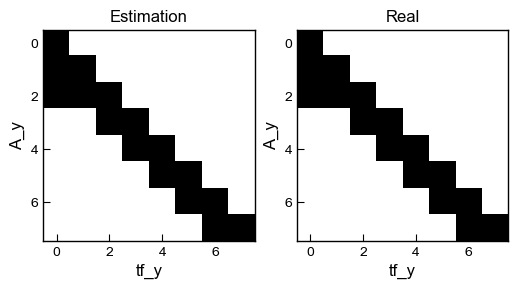

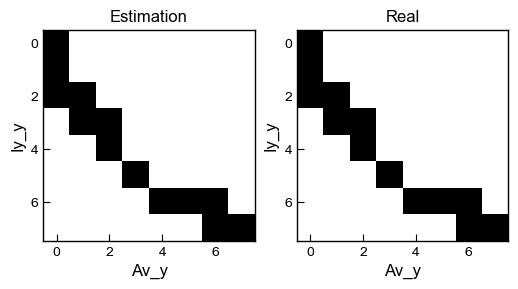

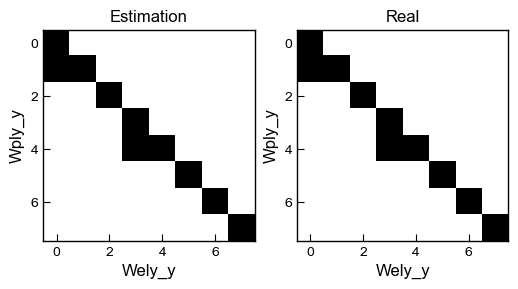

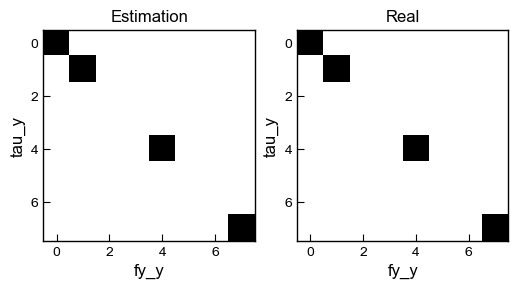

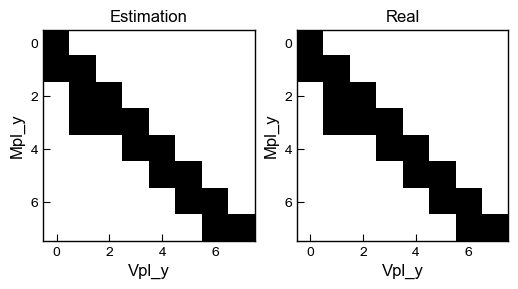

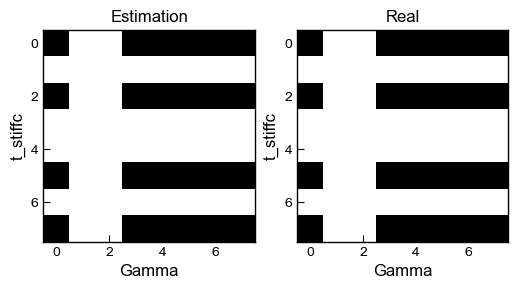

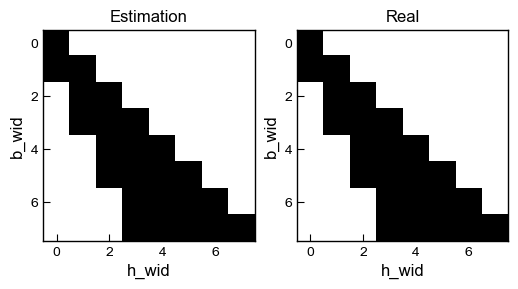

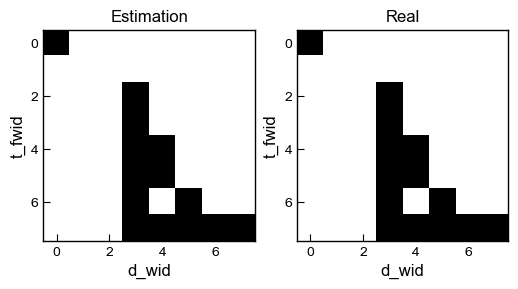

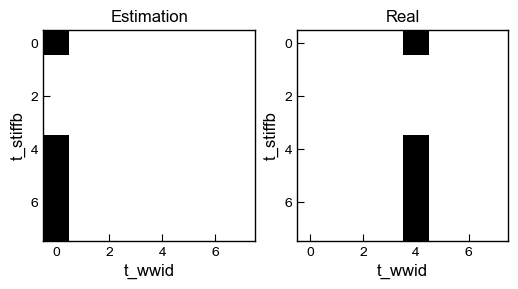

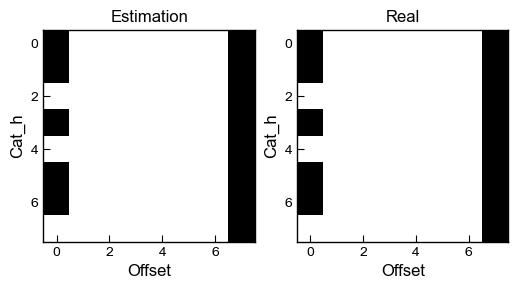

In [19]:
for i in range(len(features)//2):
    non_empty_2d = hypercubemap_unique[:,2*i:2*i+2].astype(int)
    non_empty_2d_unique = np.unique(non_empty_2d, axis=0)

    z = np.zeros((m,m))

    for x,y in non_empty_2d:
        z[x,y] += 1

    counts, _, _ = np.histogram2d(df_full[features[2*i]], df_full[features[2*i+1]], bins=m)

    fig, axs = plt.subplots(1,2, figsize=(6, 6))

    axs[0].imshow(z, cmap='Greys', interpolation='nearest', vmax=1)
    axs[1].imshow(counts, cmap='Greys', interpolation='nearest', vmax=1)

    axs[0].set_xlabel(features[2*i])
    axs[0].set_ylabel(features[2*i+1])
    axs[1].set_xlabel(features[2*i])
    axs[1].set_ylabel(features[2*i+1])

    axs[0].set_title('Estimation')
    axs[1].set_title('Real')

    plt.show()